In [3]:
import pandas as pd

df = pd.DataFrame({
    "city_name": ["Umeå", "Dresden", "Barcelona"],
    "region": ["europe", "europe", "europe"],
    "country": ["Sweden", "Germany", "Spain"],
})

df = pd.read_csv("example/boeing_locations_with_regions.csv")
df = df.drop(columns=['train_station_lat','train_station_lon','train_station_name'])
df.to_csv('100_city_sample.csv')

# Sampling origins across different cities and creating origin-destination pairs.

## Prerequisites
This repository builds on the python package OSMNx (v.2.0.1, https://osmnx.readthedocs.io/en/stable/). I recommend installing it via conda:
```
conda create -n ox -c conda-forge --strict-channel-priority osmnx
```
For sampling nodes based on city names two additional packages are required, namely geopy (v.2.3.1, https://geopy.readthedocs.io/en/stable/) and overpy (v.0.7, https://python-overpy.readthedocs.io/en/latest/)

```
pip install geopy
pip install overpy
```

For visualizing routes and geometry on maps I use the folium package (v.0.19.4, https://python-visualization.github.io/folium/latest/) that is included in the OSMNx package, but for creating static images of these visualizations the Selenium package is required (v.4.28.0, https://www.selenium.dev/documentation/)

```
pip install selenium
```

## This example
Cities are used as the basis to find random samples of intersections. The region and country names are nice to have, but they are not necessary.

In [ ]:
# The workflow for analyzing the routes begins with coordinate points used as origin locations.
import pandas as pd

df = pd.DataFrame({
    "city_name": ["Umeå", "Dresden", "Barcelona"],
    "region": ["europe", "europe", "europe"],
    "country": ["Sweden", "Germany", "Spain"],
})

df = pd.read_csv("example/boeing_locations_with_regions")
df = df.drop(['train_station_lat','train_station_lon','train_station_name'])
df.to_csv('100_city_sample.csv')
# To sample nodes from the cities we call use a method from sample_nodes.py
import node_sampling

df = node_sampling.get_random_nodes_for_all_cities(df,min_distance_km=1,sample_size=3)


display(df)

import os # for file operations

if not os.path.exists("example"):
    os.makedirs("example")
df.to_csv("example/city_samples.csv")


Random nodes for Umeå that are at least 1 km apart: [301743136, 1115417531, 302115438]
Random nodes for Umeå: [301743136, 1115417531, 302115438]
Node: 301743136
Random node coordinates for Umeå: 63.8328215, 20.1633543
Node: 1115417531
Random node coordinates for Umeå: 63.8289579, 20.3256572
Node: 302115438
Random node coordinates for Umeå: 63.8171468, 20.2294778
Random nodes for Dresden that are at least 1 km apart: [313135480, 11876129, 554183638]
Random nodes for Dresden: [313135480, 11876129, 554183638]
Node: 313135480
Random node coordinates for Dresden: 51.0548849, 13.5950345
Node: 11876129
Random node coordinates for Dresden: 51.0371832, 13.7217728
Node: 554183638
Random node coordinates for Dresden: 51.0051383, 13.7614958
Random nodes for Barcelona that are at least 1 km apart: [30295491, 2706990655, 556335003]
Random nodes for Barcelona: [30295491, 2706990655, 556335003]
Node: 30295491
Random node coordinates for Barcelona: 41.4323836, 2.1924961
Node: 2706990655
Random node coo

,city_name,country,region,network_type,node_id,node_latlon
0,Umeå,Sweden,europe,drive,301743136,"(63.8328215, 20.1633543)"
1,Umeå,Sweden,europe,drive,1115417531,"(63.8289579, 20.3256572)"
2,Umeå,Sweden,europe,drive,302115438,"(63.8171468, 20.2294778)"
3,Dresden,Germany,europe,drive,313135480,"(51.0548849, 13.5950345)"
4,Dresden,Germany,europe,drive,11876129,"(51.0371832, 13.7217728)"
5,Dresden,Germany,europe,drive,554183638,"(51.0051383, 13.7614958)"
6,Barcelona,Spain,europe,drive,30295491,"(41.4323836, 2.1924961)"
7,Barcelona,Spain,europe,drive,2706990655,"(41.4341807, 2.1645539)"
8,Barcelona,Spain,europe,drive,556335003,"(41.4096033, 2.1301305)"


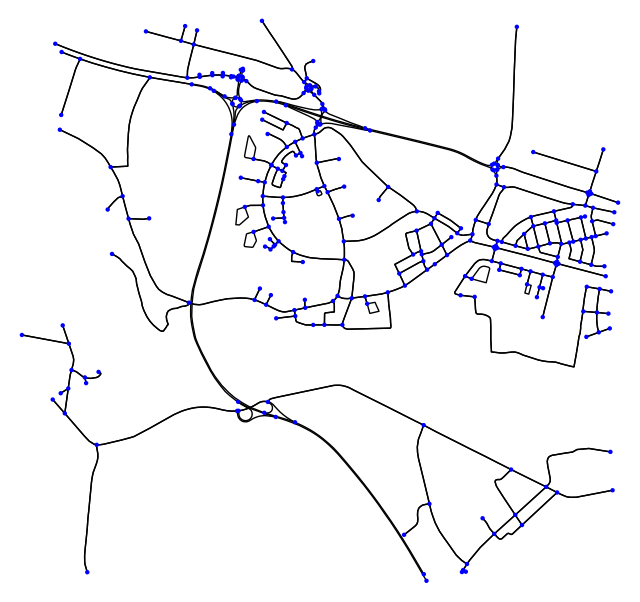

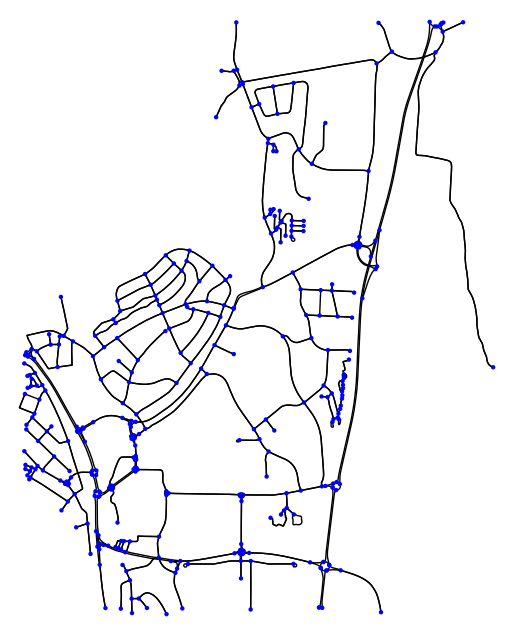

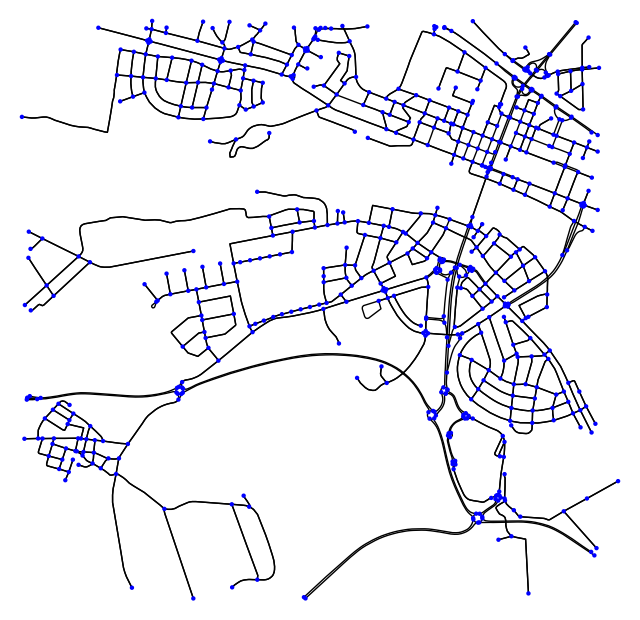

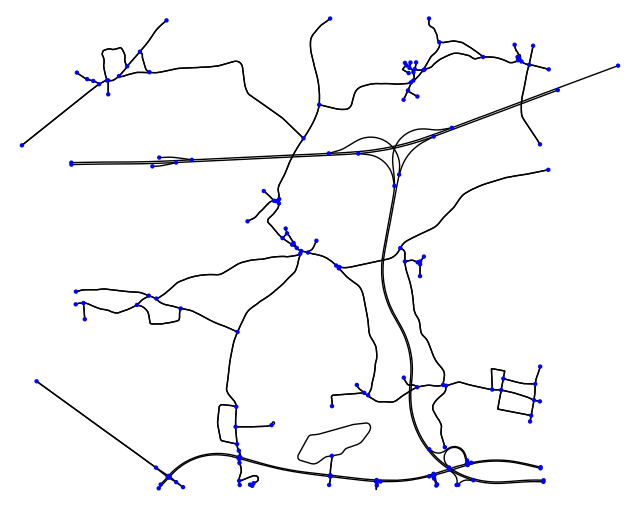

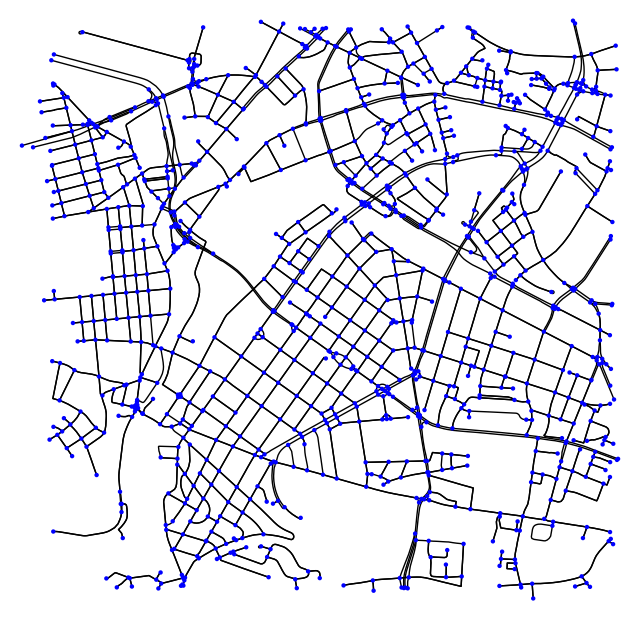

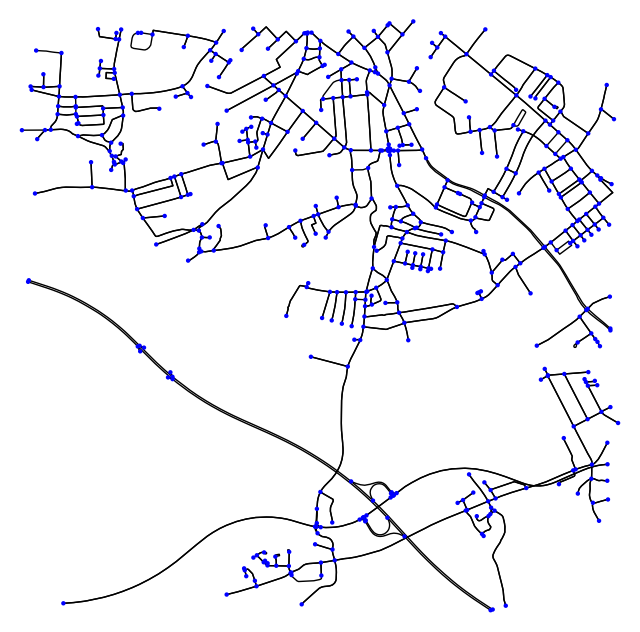

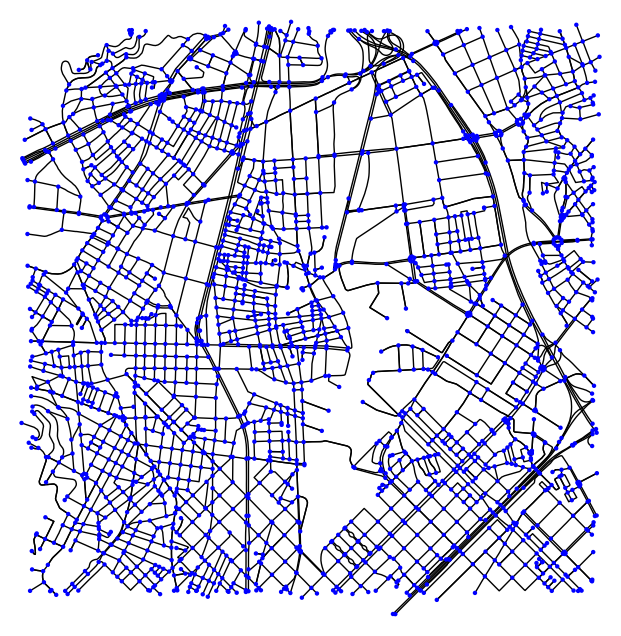

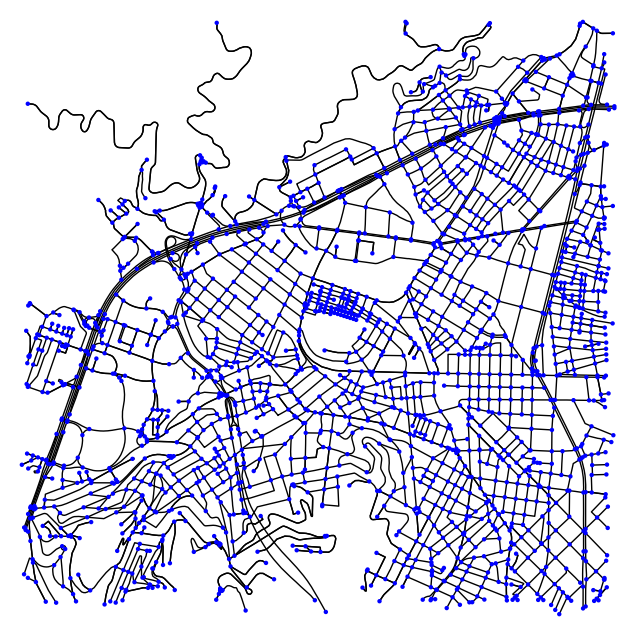

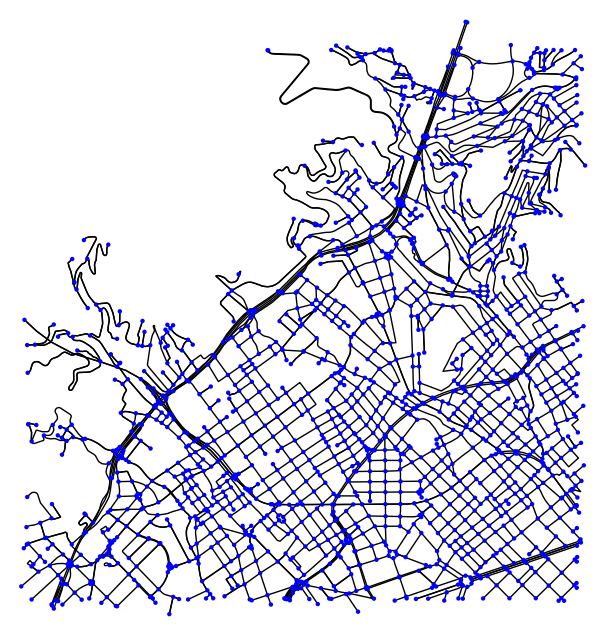

In [3]:
from origin_graph import origin_graph # for creating the origin graph object
import os # for file operations
import ast # for parsing string to tuple
import pandas as pd # for reading the csv file
import osmnx as ox # for plotting the graph
import matplotlib.pyplot as plt # for plotting the graphs
"""
The origin graph object requires the following parameters for instantiation:
# Required parameters:
- origin_point: The coordinate point of the city as a tuple (latitude, longitude)
- distance_from_point: The distance from the origin point in meters to the sides of a bounding box.
- city_name: The name of the city
- network_type: The type of network to use. The default is 'drive'.

# The following parameters are optional:
- remove_parallel: A boolean to remove parallel edges in the graph. The default is False.
- simplify: A boolean to simplify the graph. The default is False.
- edge_attr_diff: The attribute to differentiate edges in the graph when simplifying the graph. The default is None.

# Downloading a graph and weighing it can take some time. To speed up the process, you can load a graph from a file.
- save_graphml: The path to save the graphml file.
- load_graphml: The path to a graphml file to load.
"""

folder = "example/local_origin_graphs"

if not os.path.exists(folder):
    os.makedirs(folder)

df = pd.read_csv("example/city_samples.csv")

df['graph_path'] = None

for index, row in df.iterrows():
    latlon_point = ast.literal_eval(row['node_latlon'])
    og = origin_graph(origin_point=latlon_point, distance_from_point=2000,
                city_name=row["city_name"], network_type='drive', remove_parallel=True, simplify=True)
    
    graph_path = os.path.join(folder, f"{row['city_name']}_{row['node_id']}.graphml")
    og.save_graph(graph_path)

    # plot the origin graph to see if something is obviously wrong
    ox.plot_graph(og.graph, node_color='blue', node_size=10, edge_linewidth=1, edge_color='black', bgcolor='white')
    
    # Update the corresponding column in the dataframe
    df.at[index, f'graph_path'] = graph_path



df.to_csv("example/city_samples.csv",index=False)

In [1]:
# The next step is to add weights to the edges of the graph.

from origin_graph import origin_graph # for creating the origin graph object
import pandas as pd # for reading the csv file

folder = "example/local_origin_graphs"
df = pd.read_csv("example/city_samples.csv")
api_keys = pd.read_csv("api_keys.csv")
google_key = api_keys.loc[api_keys['service'] == 'Gmaps', 'key'].values[0]
for index, row in df.iterrows():
    print(f"Adding weights to graph for {row['city_name']} node id {row['node_id']}")
    og = origin_graph.from_graphml(graphml_path=row['graph_path'])

    # Adding the decision complexity weights may take some time.
    og.add_simplest_paths_from_origin()
    og.add_node_elevation(api_key=google_key)
    og.add_weights('deviation_from_prototypical')
    og.add_weights('node_degree')
    og.add_weights('instruction_equivalent')

    # We can print the edge weights to see which have been added.
    
    # Save the graph with the weights now added.
    og.save_graph(row['graph_path'])

Adding weights to graph for Umeå node id 301743136
0 edges left
Adding weights to graph for Umeå node id 1115417531
0 edges left
Adding weights to graph for Umeå node id 302115438
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 313135480
0 edges left
Adding weights to graph for Dresden node id 11876129
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 554183638
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 30295491
4000 edges left
3000 edges left
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 2706990655
3000 edges left
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 556335003
3000 edges left
2000 edges left
1000 edges left
0 edges left


In [1]:
from origin_graph import origin_graph # for creating the origin graph object
import pandas as pd # for reading the csv file

folder = "example/local_origin_graphs"
df = pd.read_csv("example/city_samples.csv")

origins_od_pair_data = []
for index, row in df.iterrows():
    print(f"Creating od-pairs for {row['city_name']} node id {row['node_id']}")
    og = origin_graph.from_graphml(graphml_path=row['graph_path'])

    """
    Parameters:
    - min_distance: The minimum distance in meters between the origin and destination points in great circle distance.
    - max distance: The maximum distance in meters between the origin and destination points in great circle distance.
    - sample_size: The number of origin-destination pairs to sample.

    Return: a dataframe with each row corresponding to an origin-destination pair.
    """
    og.create_od_pairs(min_radius=1000, max_radius=1500, sample_size=144)
    od_pair_data = og.get_od_pair_data()
    origins_od_pair_data.append(od_pair_data)

origin_od_pairs = pd.concat(origins_od_pair_data)
print(f"Number of origin-destination pairs: {len(origin_od_pairs)} in the dataset.")
print(origin_od_pairs.head(n=2))
origin_od_pairs.to_json("example/origin_od_pairs.json",orient="records",default_handler=str,indent=2)



Creating od-pairs for Umeå node id 301743136
Creating od-pairs for Umeå node id 1115417531
Creating od-pairs for Umeå node id 302115438
Creating od-pairs for Dresden node id 313135480
Creating od-pairs for Dresden node id 11876129
Creating od-pairs for Dresden node id 554183638
Creating od-pairs for Barcelona node id 30295491
Creating od-pairs for Barcelona node id 2706990655
Creating od-pairs for Barcelona node id 556335003
Number of origin-destination pairs: 841 in the dataset.
                     id city_name  origin_node              origin_point  \
0  301743136-9163309700      Umeå    301743136  (63.8328215, 20.1633543)   
1  301743136-1999192328      Umeå    301743136  (63.8328215, 20.1633543)   

   origin_elevation  destination_node         destination_point  \
0         26.591532        9163309700  (63.8443543, 20.1682096)   
1         26.591532        1999192328  (63.8415075, 20.1556884)   

   destination_elevation  elevation_difference  od_distance  ...  \
0              2

In [3]:
import post_processing
import pandas as pd
od_pair_data = pd.read_json("example/origin_od_pairs.json")

od_pair_data = post_processing.label_length_outliers(od_pair_data)
od_pair_data = post_processing.label_gridlike_groups(od_pair_data)

# Before normalizing the complexity, we need to remove the length outliers.
print(f"od-pairs before removing length outliers {len(od_pair_data)}")
od_pair_data = od_pair_data[od_pair_data['length_outliers'] == False]
print(f"od-pairs after removing length outliers {len(od_pair_data)}")
od_pair_data = post_processing.normalize_complexity(od_pair_data)

# The od-pair data contains lists and dictionaries that are not easily saved to a csv file, so we store it as a json file.
# Still, there some columns that need to be serialized to strings such as shapely polygon objects.
od_pair_data.to_json("example/origin_od_pairs.json",orient="records",default_handler=str,indent=2)

od-pairs before removing length outliers 845
od-pairs after removing length outliers 802
max complexity: 115 sum of columns: 41052, mean: 51.18703241895262, median: 51.0
max complexity: 93 sum of columns: 34640, mean: 43.19201995012469, median: 43.0
max complexity: 1.0 sum of columns: 356.9739130434783, mean: 0.44510462973002285, median: 0.4434782608695652
max complexity: 0.808695652173913 sum of columns: 301.21739130434787, mean: 0.37558278217499735, median: 0.3739130434782609


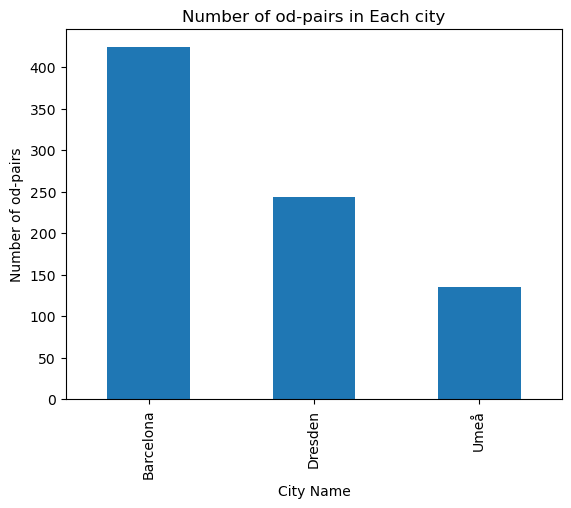

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

od_pair_data = pd.read_json("example/origin_od_pairs.json")


od_pair_data['closest_strongest_lag'] = abs(od_pair_data['closest_strongest_lag'])

od_pair_data = od_pair_data.sort_values(by="closest_strongest_lag", ascending=True)


city_counts = od_pair_data['city_name'].value_counts()
city_counts.plot(kind='bar')
plt.xlabel('City Name')
plt.ylabel('Number of od-pairs')
plt.title('Number of od-pairs in Each city')
plt.show()